In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded processor from checkpoint.


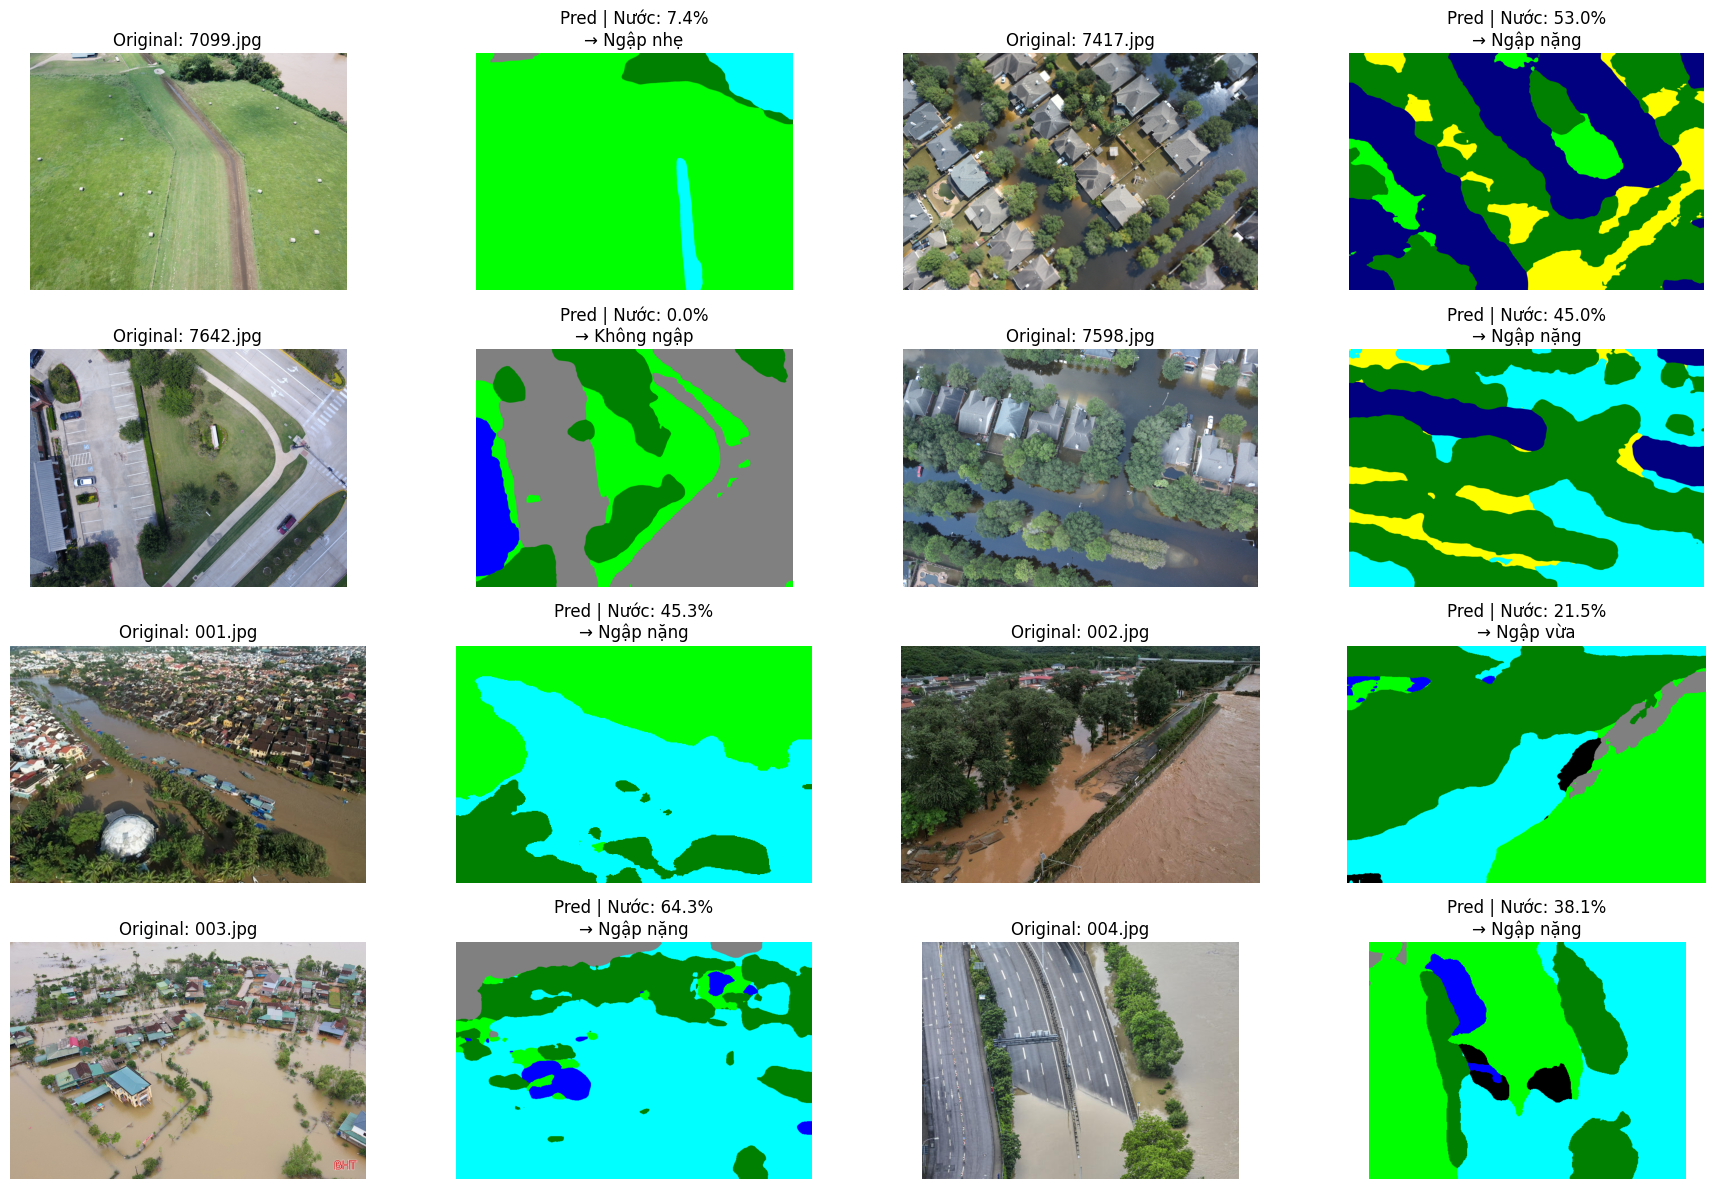


KẾT QUẢ INFERENCE TRÊN VALIDATION
7099.jpg     | Nước: 7.37% | Mức ngập: 1 → Ngập nhẹ
7417.jpg     | Nước: 53.01% | Mức ngập: 3 → Ngập nặng
7642.jpg     | Nước: 0.00% | Mức ngập: 0 → Không ngập
7598.jpg     | Nước: 45.02% | Mức ngập: 3 → Ngập nặng
001.jpg      | Nước: 45.34% | Mức ngập: 3 → Ngập nặng
002.jpg      | Nước: 21.53% | Mức ngập: 2 → Ngập vừa
003.jpg      | Nước: 64.28% | Mức ngập: 3 → Ngập nặng
004.jpg      | Nước: 38.15% | Mức ngập: 3 → Ngập nặng


In [ ]:
# === segmentation_inference.py ===

import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# === CẤU HÌNH ===
# Chọn model tốt nhất
MODEL_PATH = "/content/drive/MyDrive/CODE/KHKT/checkpoints/segformer_floodnet_epoch15"

# Nếu trong checkpoint đã lưu processor thì load từ đó (khớp 100% với train)
try:
    processor = SegformerImageProcessor.from_pretrained(
        MODEL_PATH,
        local_files_only=True
    )
    print("Loaded processor from checkpoint.")
except Exception:
    # fallback: dùng processor gốc
    processor = SegformerImageProcessor.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        do_reduce_labels=False,
        size={"height": 512, "width": 512}
    )
    print("Loaded default processor from base model.")

# Load model
id2label = {
    0: "background",
    1: "building_flooded",
    2: "building_non_flooded",
    3: "road_flooded",
    4: "road_non_flooded",
    5: "water",
    6: "tree",
    7: "vehicle",
    8: "pool",
    9: "grass",
}
label2id = {v: k for k, v in id2label.items()}

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_PATH,
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    local_files_only=True
)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# === MÀU CHO TỪNG CLASS ===
id2color = {
    0: (0, 0, 0),        # background
    1: (0, 0, 128),      # building flooded
    2: (0, 0, 255),      # building non-flooded
    3: (255, 255, 0),    # road flooded
    4: (128, 128, 128),  # road non-flooded
    5: (0, 255, 255),    # water
    6: (0, 128, 0),      # tree
    7: (255, 0, 0),      # vehicle
    8: (128, 0, 0),      # pool
    9: (0, 255, 0),      # grass
}

# === HÀM INFERENCE CHÍNH ===
def predict_flood_level(image_path):
    # 1. Đọc ảnh
    image = Image.open(image_path).convert("RGB")

    # 2. Preprocess
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)

    # 3. Inference
    with torch.no_grad():
        outputs = model(pixel_values)
        logits = outputs.logits  # (1, 10, h, w)

    # 4. Upsample về kích thước ảnh gốc
    upsampled_logits = F.interpolate(
        logits,
        size=image.size[::-1],  # (H, W)
        mode="bilinear",
        align_corners=False
    )
    seg = upsampled_logits.argmax(dim=1)[0].cpu().numpy()  # (H, W)

    # 5. Tính tỉ lệ nước
    flood_classes = [1, 3, 5]
    water_ratio = np.isin(seg, flood_classes).sum() / seg.size


    # 6. Phân mức ngập theo tỉ lệ water
    if water_ratio < 0.05:
        level, level_text = 0, "Không ngập"
    elif water_ratio < 0.1:
        level, level_text = 1, "Ngập nhẹ"
    elif water_ratio < 0.3:
        level, level_text = 2, "Ngập vừa"
    else:
        level, level_text = 3, "Ngập nặng"

    # 7. Tạo mask màu đẹp
    h, w = seg.shape
    mask_colored = np.zeros((h, w, 3), dtype=np.uint8)
    for label, color in id2color.items():
        mask_colored[seg == label] = color

    return {
        "original": image,
        "segmentation": mask_colored,
        "seg_map": seg,
        "water_ratio": water_ratio,
        "flood_level": level,
        "flood_text": level_text
    }

# === TEST TRÊN MỘT SỐ ẢNH VALIDATION ===
if __name__ == "__main__":
    val_dir = "/content/drive/MyDrive/CODE/KHKT/FloodNet/validation/img"
    test_images = ["7099.jpg", "7417.jpg", "7642.jpg", "7598.jpg",
                    "001.jpg", "002.jpg", "003.jpg", "004.jpg"]

    plt.figure(figsize=(18, 12))
    rows, cols = 4, 4

    for i, img_name in enumerate(test_images[:8], 1):
        img_path = os.path.join(val_dir, img_name)
        if not os.path.exists(img_path):
            print(f"Không tìm thấy: {img_path}")
            continue

        result = predict_flood_level(img_path)

        plt.subplot(rows, cols, i * 2 - 1)
        plt.imshow(result["original"])
        plt.title(f"Original: {img_name}")
        plt.axis("off")

        plt.subplot(rows, cols, i * 2)
        plt.imshow(result["segmentation"])
        plt.title(f"Pred | Nước: {result['water_ratio']:.1%}\n→ {result['flood_text']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("\n" + "=" * 60)
    print("KẾT QUẢ INFERENCE TRÊN VALIDATION")
    print("=" * 60)
    for img_name in test_images:
        img_path = os.path.join(val_dir, img_name)
        if not os.path.exists(img_path):
            continue
        r = predict_flood_level(img_path)
        print(f"{img_name:12} | Nước: {r['water_ratio']:.2%} | Mức ngập: {r['flood_level']} → {r['flood_text']}")

## Tạo Pseudo-mask

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

# === COPY MODEL ĐÃ TRAIN ===
!cp -r "/content/drive/MyDrive/CODE/KHKT/checkpoints/segformer_floodnet_epoch6" ./temp_model
MODEL_PATH = "./temp_model"

print("Loading model từ folder local...")
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_PATH,
    local_files_only=True
).cuda()


CONF_THRESHOLD = 0.60

processor = SegformerImageProcessor.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    do_reduce_labels=False,
    size={"height": 512, "width": 512}
)

VAL_IMG_DIR = "/content/drive/MyDrive/CODE/KHKT/FloodNet/validation/img"
PSEUDO_LABEL_DIR = "/content/drive/MyDrive/CODE/KHKT/FloodNet/validation/pseudo_mask"
os.makedirs(PSEUDO_LABEL_DIR, exist_ok=True)

model.eval()


# TẠO BẢNG MAPPING ADE → FLOODNET
id2label_ade = model.config.id2label

def build_ade_to_floodnet_lut(id2label):
    """
    Trả về lookup table (numpy array) map mỗi ADE id -> FloodNet id.
    """
    mapping = {}
    for k, name in id2label.items():
        k = int(k)
        n = name.lower()

        cls = 0  # mặc định background

        # ƯU TIÊN POOL TRƯỚC
        if "pool" in n:
            cls = 8  # pool

        # NƯỚC
        elif any(w in n for w in ["river", "sea", "lake", "water", "ocean"]):
            cls = 5  # water

        # BUILDING
        elif any(w in n for w in ["building", "house", "skyscraper", "tower", "garage", "hut"]):
            cls = 2  # building non-flooded

        # ROAD
        elif any(w in n for w in ["road", "street", "highway", "runway", "path", "railroad"]):
            cls = 4  # road non-flooded

        # VEHICLE
        elif any(w in n for w in ["car", "truck", "bus", "van", "vehicle", "train", "motorcycle", "bike", "bicycle"]):
            cls = 7  # vehicle

        # TREE / VEGETATION
        elif any(w in n for w in ["tree", "forest", "plant", "bush", "shrub"]):
            cls = 6  # tree

        # GRASS / FIELD
        elif any(w in n for w in ["grass", "field", "lawn", "meadow"]):
            cls = 9  # grass

        # Flooded (1,3) KHÔNG MAP ĐƯỢC TỪ ADE → tạm thời không dùng
        mapping[k] = cls

    max_id = max(mapping.keys())
    lut = np.zeros(max_id + 1, dtype=np.uint8)
    for k, v in mapping.items():
        lut[k] = v
    return lut

ade2flood_lut = build_ade_to_floodnet_lut(id2label_ade)
print("Mapping ADE150 → FloodNet10 đã sẵn sàng.")

print("Bắt đầu tạo pseudo-label cho validation...\n")

for img_name in tqdm(os.listdir(VAL_IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        continue

    img_path = os.path.join(VAL_IMG_DIR, img_name)
    image = Image.open(img_path).convert("RGB")

    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values.cuda()

    with torch.no_grad():
        logits = model(pixel_values).logits    # (1, C_ade, h, w) - kích thước nhỏ hơn ảnh gốc

        probs = torch.softmax(logits, dim=1)[0]      # (C_ade, h, w)
        conf, pred_ade = probs.max(dim=0)            # (h, w), conf là max prob

    # Up-sample lên kích thước ảnh gốc
    H, W = image.size[1], image.size[0]  # (H, W)

    pred_ade_up = F.interpolate(
        pred_ade.unsqueeze(0).unsqueeze(0).float(),  # (1,1,h,w)
        size=(H, W),
        mode="nearest"
    )[0, 0].cpu().numpy().astype(np.int64)           # (H, W)

    conf_up = F.interpolate(
        conf.unsqueeze(0).unsqueeze(0),              # (1,1,h,w)
        size=(H, W),
        mode="bilinear",
        align_corners=False
    )[0, 0].cpu().numpy()                            # (H, W)

    # Lọc pixel không tự tin
    pred_ade_up[conf_up < CONF_THRESHOLD] = 0

    # Map ADE → FloodNet
    pred_flood = ade2flood_lut[pred_ade_up]          # (H, W)

    save_path = os.path.join(
        PSEUDO_LABEL_DIR,
        img_name.rsplit(".", 1)[0] + "_lab.png"
    )
    Image.fromarray(pred_flood.astype(np.uint8)).save(save_path)

    del logits, probs, conf, pred_ade, pred_ade_up, conf_up
    torch.cuda.empty_cache()

print(f"\nHOÀN TẤT! Đã tạo {len(os.listdir(PSEUDO_LABEL_DIR))} pseudo masks (FloodNet 10 lớp, nhưng chưa phân biệt flooded/non-flooded).")

Loading model từ folder local...


/usr/local/lib/python3.12/dist-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


Mapping ADE150 → FloodNet10 đã sẵn sàng.
Bắt đầu tạo pseudo-label cho validation...



100%|██████████| 454/454 [04:25<00:00,  1.71it/s]


HOÀN TẤT! Đã tạo 454 pseudo masks (FloodNet 10 lớp, nhưng chưa phân biệt flooded/non-flooded).


## Test trên tập test

In [ ]:
# ==================== segmentation_test.py ====================
# Script đánh giá model SegFormer FloodNet trên TEST SET

import torch
import torch.nn.functional as F
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# ==================== CẤU HÌNH ====================
MODEL_PATH = "/content/drive/MyDrive/CODE/KHKT/checkpoints/segformer_floodnet_epoch15"
TEST_DIR = "/content/drive/MyDrive/CODE/KHKT/FloodNet/test/img"
SAVE_DIR = "/content/drive/MyDrive/CODE/KHKT/FloodNet/test_results"
os.makedirs(SAVE_DIR, exist_ok=True)

# Load processor
try:
    processor = SegformerImageProcessor.from_pretrained(
        MODEL_PATH,
        local_files_only=True
    )
    print("Loaded processor from checkpoint.")
except:
    processor = SegformerImageProcessor.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        do_reduce_labels=False,
        size={"height": 512, "width": 512}
    )
    print("Loaded default base processor.")

# Label mapping (FloodNet 0–9)
id2label = {
    0: "background",
    1: "building_flooded",
    2: "building_non_flooded",
    3: "road_flooded",
    4: "road_non_flooded",
    5: "water",
    6: "tree",
    7: "vehicle",
    8: "pool",
    9: "grass",
}
label2id = {v: k for k, v in id2label.items()}

# Load model
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_PATH,
    num_labels=10,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    local_files_only=True
)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Color map
id2color = {
    0: (0, 0, 0),
    1: (0, 0, 128),
    2: (0, 0, 255),
    3: (255, 255, 0),
    4: (128, 128, 128),
    5: (0, 255, 255),
    6: (0, 128, 0),
    7: (255, 0, 0),
    8: (128, 0, 0),
    9: (0, 255, 0),
}

# === HÀM INFERENCE ===
def predict(image_path):

    image = Image.open(image_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)

    with torch.no_grad():
        logits = model(pixel_values).logits

    upsampled = F.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False
    )
    seg = upsampled.argmax(1)[0].cpu().numpy()

    flood_classes = [1, 3, 5]  # flooded building, flooded road, water
    water_ratio = np.isin(seg, flood_classes).sum() / seg.size

    if water_ratio < 0.05:
        level, level_text = 0, "Không ngập"
    elif water_ratio < 0.1:
        level, level_text = 1, "Ngập nhẹ"
    elif water_ratio < 0.3:
        level, level_text = 2, "Ngập vừa"
    else:
        level, level_text = 3, "Ngập nặng"

    # Tạo mask màu
    h, w = seg.shape
    mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cid, color in id2color.items():
        mask[seg == cid] = color

    return image, mask, water_ratio, level_text

# === CHẠY TEST ===
results = []

test_images = sorted(os.listdir(TEST_DIR))
test_images = [f for f in test_images if f.lower().endswith((".jpg", ".png", ".jpeg"))]

print(f"Found {len(test_images)} test images.")

for img_name in test_images:
    img_path = os.path.join(TEST_DIR, img_name)

    original, mask, water_ratio, level_text = predict(img_path)

    # Lưu ảnh segmentation
    save_path = os.path.join(SAVE_DIR, img_name.replace(".jpg", "_seg.png"))
    Image.fromarray(mask).save(save_path)

    # Lưu kết quả vào list
    results.append({
        "filename": img_name,
        "water_ratio": water_ratio,
        "flood_level": level_text
    })

# === LƯU CSV ===
df = pd.DataFrame(results)
csv_path = os.path.join(SAVE_DIR, "test_results.csv")
df.to_csv(csv_path, index=False)

print("\n===== TỔNG KẾT TEST =====")
print(df.head())
print(f"\nSaved CSV: {csv_path}")

print("\nThống kê tổng hợp:")
print(df["flood_level"].value_counts())
print(f"Tỉ lệ ngập trung bình: {df['water_ratio'].mean():.3f}")

Loaded processor from checkpoint.
Found 448 test images.

===== TỔNG KẾT TEST =====
    filename  water_ratio flood_level
0  10163.jpg     1.000000   Ngập nặng
1  10164.jpg     1.000000   Ngập nặng
2  10167.jpg     0.987956   Ngập nặng
3  10174.jpg     0.000000  Không ngập
4  10183.jpg     0.000000  Không ngập

Saved CSV: /content/drive/MyDrive/CODE/KHKT/FloodNet/test_results/test_results.csv

Thống kê tổng hợp:
flood_level
Không ngập    261
Ngập nặng     103
Ngập vừa       53
Ngập nhẹ       31
Name: count, dtype: int64
Tỉ lệ ngập trung bình: 0.169
